In [12]:
# Cell 1: 环境检测 + 安装依赖
import subprocess, sys

def ensure_package(pkg, import_name=None):
    try:
        __import__(import_name or pkg)
    except ImportError:
        print(f"安装 {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

ensure_package("torch")
ensure_package("scikit-learn", "sklearn")

import torch
print(f"PyTorch {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch 2.10.0+cpu
CUDA available: False
Using device: cpu


In [13]:
# Cell 2: 加载数据 + 特征选择
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("../processed_data/processed_psi_douyin.csv")
print(f"数据: {df.shape[0]} 行, {df.shape[1]} 列")

TARGET = 'future_1s_some'

# ========== V2: 不只用原始特征，加入关键工程特征 ==========
# 小数据下 LSTM 自身无法有效学到 rolling/diff 模式，需要人工喂入
FEATURES = [
    # 原始时序信号 (10)
    'some_delta', 'full_delta', 'mem_available',
    'pgscan_direct', 'pgsteal_direct', 'pgmajfault',
    'workingset_refault', 'allocstall', 'pswpin', 'pswpout',
    # 趋势 (4)
    'diff_some', 'diff_full', 'diff_pgscan', 'mem_drop',
    # 短期统计 (4)
    'some_std_6', 'pgscan_std_6', 'some_ewm_6', 'full_ewm_6',
    # 关键比率 (3)
    'alloc_pgscan_ratio', 'reclaim_efficiency', 'some_zscore_6',
]
# 过滤掉不存在的列
FEATURES = [f for f in FEATURES if f in df.columns]

print(f"输入特征 ({len(FEATURES)}): {FEATURES}")
print(f"目标: {TARGET}")

# ========== 关键: Log1p 变换目标 ==========
# future_1s_some 分布: 0 ~ 680000, 严重右偏
# log1p 压缩到 0 ~ 13.4，分布接近正态
df['target_log'] = np.log1p(df[TARGET])
print(f"\n原始目标分布:")
print(f"  range: [{df[TARGET].min():.0f}, {df[TARGET].max():.0f}] μs")
print(f"  mean={df[TARGET].mean():.0f}, median={df[TARGET].median():.0f}, std={df[TARGET].std():.0f}")
print(f"\nLog1p 变换后:")
print(f"  range: [{df['target_log'].min():.2f}, {df['target_log'].max():.2f}]")
print(f"  mean={df['target_log'].mean():.2f}, median={df['target_log'].median():.2f}, std={df['target_log'].std():.2f}")

数据: 4683 行, 74 列
输入特征 (21): ['some_delta', 'full_delta', 'mem_available', 'pgscan_direct', 'pgsteal_direct', 'pgmajfault', 'workingset_refault', 'allocstall', 'pswpin', 'pswpout', 'diff_some', 'diff_full', 'diff_pgscan', 'mem_drop', 'some_std_6', 'pgscan_std_6', 'some_ewm_6', 'full_ewm_6', 'alloc_pgscan_ratio', 'reclaim_efficiency', 'some_zscore_6']
目标: future_1s_some

原始目标分布:
  range: [0, 680090] μs
  mean=29895, median=3970, std=62872

Log1p 变换后:
  range: [0.00, 13.43]
  mean=8.23, median=8.29, std=2.43


In [14]:
# Cell 3: 按会话切分 + RobustScaler (抗异常值)
from sklearn.preprocessing import RobustScaler, StandardScaler

sessions = df['source_file'].unique()
print(f"会话数: {len(sessions)}")
for s in sessions:
    n = (df['source_file'] == s).sum()
    spike_rate = df.loc[df['source_file'] == s, 'is_spike_some'].mean()
    print(f"  {s}: {n} 行, 正样本率={spike_rate:.2%}")

# 前 3 个 session 训练，最后 1 个 session 测试
train_sessions = sessions[:-1]
test_session = sessions[-1]

train_df = df[df['source_file'].isin(train_sessions)].copy()
test_df = df[df['source_file'] == test_session].copy()

print(f"\n训练集: {len(train_df)} 行")
print(f"测试集: {len(test_df)} 行")

# ========== 对特征用 RobustScaler (中位数+IQR，不受极端值干扰) ==========
scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(train_df[FEATURES].values)
X_test_scaled = scaler_X.transform(test_df[FEATURES].values)

# ========== 对 log1p 目标用 StandardScaler ==========
scaler_y = StandardScaler()
y_train_log = train_df['target_log'].values.reshape(-1, 1)
y_test_log = test_df['target_log'].values.reshape(-1, 1)
scaler_y.fit(y_train_log)
y_train_scaled = scaler_y.transform(y_train_log).ravel()
y_test_scaled = scaler_y.transform(y_test_log).ravel()

print(f"\n特征缩放: RobustScaler")
print(f"目标变换: log1p → StandardScaler")
print(f"y_train_scaled range: [{y_train_scaled.min():.2f}, {y_train_scaled.max():.2f}]")
print(f"y_test_scaled range:  [{y_test_scaled.min():.2f}, {y_test_scaled.max():.2f}]")

会话数: 4
  psi_douyin_20260228_211328.csv: 997 行, 正样本率=11.03%
  psi_douyin_20260228_213146.csv: 1241 行, 正样本率=12.09%
  psi_douyin_20260228_215103.csv: 1220 行, 正样本率=8.52%
  psi_douyin_20260228_221442.csv: 1225 行, 正样本率=8.57%

训练集: 3458 行
测试集: 1225 行

特征缩放: RobustScaler
目标变换: log1p → StandardScaler
y_train_scaled range: [-3.35, 2.10]
y_test_scaled range:  [-2.79, 1.91]


In [15]:
# Cell 4: 构造滑动窗口序列 + 数据增强
import torch
from torch.utils.data import Dataset, DataLoader

SEQ_LEN = 16  # 过去 16 步 (8 秒)，比 20 稍短减少数据损失

class PSISequenceDataset(Dataset):
    """滑动窗口时序数据集，支持 jitter 增强"""
    def __init__(self, X_scaled, y_scaled, seq_len, session_boundaries=None,
                 augment=False, jitter_std=0.02):
        self.seq_len = seq_len
        self.augment = augment
        self.jitter_std = jitter_std
        self.X_seqs = []
        self.y_vals = []
        
        if session_boundaries is None:
            session_boundaries = [(0, len(X_scaled))]
        
        for start, end in session_boundaries:
            X_sess = X_scaled[start:end]
            y_sess = y_scaled[start:end]
            for i in range(seq_len, len(X_sess)):
                self.X_seqs.append(X_sess[i - seq_len:i])
                self.y_vals.append(y_sess[i])
        
        self.X_seqs = np.array(self.X_seqs, dtype=np.float32)
        self.y_vals = np.array(self.y_vals, dtype=np.float32)
    
    def __len__(self):
        return len(self.y_vals)
    
    def __getitem__(self, idx):
        x = self.X_seqs[idx].copy()
        if self.augment:
            # 训练时加小噪声防止过拟合
            x += np.random.normal(0, self.jitter_std, x.shape).astype(np.float32)
        return torch.tensor(x), torch.tensor(self.y_vals[idx])

# 计算会话边界
train_boundaries = []
offset = 0
for s in train_sessions:
    n = (train_df['source_file'] == s).sum()
    train_boundaries.append((offset, offset + n))
    offset += n

test_boundaries = [(0, len(X_test_scaled))]

train_dataset = PSISequenceDataset(X_train_scaled, y_train_scaled, SEQ_LEN, 
                                    train_boundaries, augment=True, jitter_std=0.02)
test_dataset = PSISequenceDataset(X_test_scaled, y_test_scaled, SEQ_LEN, test_boundaries)

BATCH_SIZE = 32  # 小 batch 更好的梯度噪声正则化
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"窗口长度: {SEQ_LEN} (约{SEQ_LEN * 0.5:.0f}秒)")
print(f"训练序列: {len(train_dataset)}, 测试序列: {len(test_dataset)}")
print(f"每条形状: ({SEQ_LEN}, {len(FEATURES)})")
print(f"Batch: {BATCH_SIZE}, 训练时加 jitter 增强")

窗口长度: 16 (约8秒)
训练序列: 3410, 测试序列: 1209
每条形状: (16, 21)
Batch: 32, 训练时加 jitter 增强


In [16]:
# Cell 5: 模型定义 (GRU + Multi-head Attention + 多尺度卷积)
import torch.nn as nn

class PSI_Model(nn.Module):
    """
    V2: 1D-Conv 多尺度特征提取 → GRU 时序建模 → Multi-head Attention → 回归输出
    GRU 参数量比 LSTM 少 25%，小数据下不容易过拟合
    """
    def __init__(self, input_dim, hidden_dim=96, n_layers=2, dropout=0.4, n_heads=4):
        super().__init__()
        
        # ========== 1D 卷积: 多尺度局部特征提取 ==========
        self.conv3 = nn.Conv1d(input_dim, hidden_dim // 2, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(input_dim, hidden_dim // 2, kernel_size=5, padding=2)
        self.conv_norm = nn.LayerNorm(hidden_dim)
        self.conv_drop = nn.Dropout(dropout * 0.5)
        
        # ========== GRU ==========
        self.gru = nn.GRU(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
            bidirectional=False,
        )
        
        # ========== Multi-head Attention ==========
        self.mha = nn.MultiheadAttention(hidden_dim, n_heads, dropout=dropout, batch_first=True)
        self.attn_norm = nn.LayerNorm(hidden_dim)
        
        # ========== 输出头 ==========
        self.head = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 32),
            nn.GELU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(32, 1),
        )
    
    def forward(self, x):
        # x: (B, T, D)
        B, T, D = x.shape
        
        # 1D Conv (需要 B, D, T 格式)
        x_conv = x.permute(0, 2, 1)
        c3 = torch.relu(self.conv3(x_conv))  # (B, H/2, T)
        c5 = torch.relu(self.conv5(x_conv))  # (B, H/2, T)
        x_conv = torch.cat([c3, c5], dim=1).permute(0, 2, 1)  # (B, T, H)
        x_conv = self.conv_drop(self.conv_norm(x_conv))
        
        # GRU
        gru_out, _ = self.gru(x_conv)  # (B, T, H)
        
        # Multi-head Attention
        attn_out, attn_weights = self.mha(gru_out, gru_out, gru_out)
        attn_out = self.attn_norm(attn_out + gru_out)  # 残差
        
        # 拼接: 注意力加权平均 + 最后时间步
        context = attn_out.mean(dim=1)       # (B, H) 全局平均
        last_h = gru_out[:, -1, :]           # (B, H) 最后时间步
        fused = torch.cat([context, last_h], dim=-1)  # (B, 2*H)
        
        return self.head(fused).squeeze(-1)  # (B,)

model = PSI_Model(
    input_dim=len(FEATURES),
    hidden_dim=96,
    n_layers=2,
    dropout=0.4,
    n_heads=4
).to(device)

n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"模型参数量: {n_params:,}")
print(model)

模型参数量: 179,201
PSI_Model(
  (conv3): Conv1d(21, 48, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv5): Conv1d(21, 48, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv_norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (conv_drop): Dropout(p=0.2, inplace=False)
  (gru): GRU(96, 96, num_layers=2, batch_first=True, dropout=0.4)
  (mha): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
  )
  (attn_norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (head): Sequential(
    (0): Linear(in_features=192, out_features=96, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=96, out_features=32, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [17]:
# Cell 6: 训练循环 (加权 Huber Loss + OneCycleLR + 更大 patience)
import time

# ========== 加权损失: 高压区域权重更大 ==========
class WeightedHuberLoss(nn.Module):
    """对高压力值(预测卡顿更重要)给予更高权重"""
    def __init__(self, delta=1.0, high_weight=3.0, threshold=0.5):
        super().__init__()
        self.huber = nn.HuberLoss(delta=delta, reduction='none')
        self.high_weight = high_weight
        self.threshold = threshold  # 标准化后的阈值 (大约对应偏高的 some 值)
    
    def forward(self, pred, target):
        loss = self.huber(pred, target)
        # target > threshold 的区域给更高权重
        weights = torch.where(target > self.threshold, self.high_weight, 1.0)
        return (loss * weights).mean()

# ========== 超参数 ==========
EPOCHS = 150
LR = 3e-3
WEIGHT_DECAY = 1e-3
PATIENCE = 25

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR, epochs=EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.15,  # 15% warmup
    anneal_strategy='cos',
    div_factor=10, final_div_factor=100,
)
criterion = WeightedHuberLoss(delta=1.0, high_weight=3.0, threshold=0.5)

# ========== 训练 ==========
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_epoch = 0
best_state = None

print(f"开始训练: {EPOCHS} epochs, lr={LR}, patience={PATIENCE}")
print(f"损失: WeightedHuberLoss (高压区域 3x 权重)")
print(f"调度: OneCycleLR (15% warmup)")
print("-" * 65)

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    
    # --- Train ---
    model.train()
    epoch_loss = 0
    n_batches = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        epoch_loss += loss.item()
        n_batches += 1
    
    train_loss = epoch_loss / n_batches
    train_losses.append(train_loss)
    
    # --- Validation ---
    model.eval()
    val_loss = 0
    val_n = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(X_batch)
            val_loss += nn.HuberLoss(reduction='sum')(pred, y_batch).item()
            val_n += len(y_batch)
    
    val_loss /= val_n
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    
    elapsed = time.time() - t0
    if epoch % 10 == 0 or epoch <= 3:
        lr_now = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch:3d}/{EPOCHS} | train={train_loss:.4f} | val={val_loss:.4f} | "
              f"best={best_val_loss:.4f}@{best_epoch} | lr={lr_now:.5f} | {elapsed:.1f}s")
    
    if epoch - best_epoch >= PATIENCE:
        print(f"\n✓ Early stopping at epoch {epoch} (best={best_epoch})")
        break

model.load_state_dict(best_state)
model = model.to(device)
print(f"\n✓ 训练完成, best epoch={best_epoch}, val_loss={best_val_loss:.4f}")

开始训练: 150 epochs, lr=0.003, patience=25
损失: WeightedHuberLoss (高压区域 3x 权重)
调度: OneCycleLR (15% warmup)
-----------------------------------------------------------------
Epoch   1/150 | train=0.6175 | val=0.4095 | best=0.4095@1 | lr=0.00031 | 1.8s
Epoch   2/150 | train=0.5295 | val=0.4220 | best=0.4095@1 | lr=0.00035 | 1.7s
Epoch   3/150 | train=0.5001 | val=0.4610 | best=0.4095@1 | lr=0.00042 | 1.8s
Epoch  10/150 | train=0.3673 | val=0.4182 | best=0.3959@6 | lr=0.00142 | 1.7s
Epoch  20/150 | train=0.2502 | val=0.4804 | best=0.3959@6 | lr=0.00292 | 1.6s
Epoch  30/150 | train=0.2040 | val=0.4174 | best=0.3959@6 | lr=0.00297 | 1.7s

✓ Early stopping at epoch 31 (best=6)

✓ 训练完成, best epoch=6, val_loss=0.3959


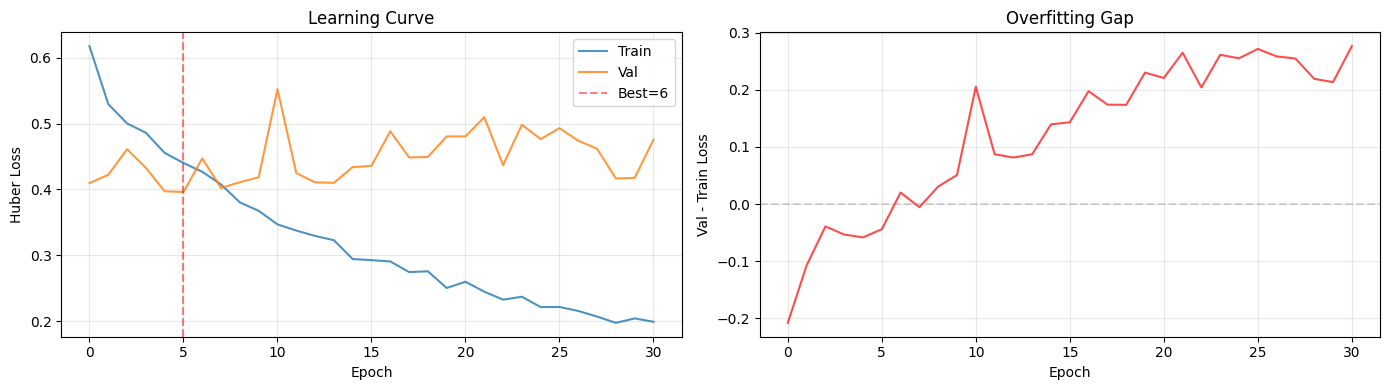

In [18]:
# Cell 7: 学习曲线
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 左图: Loss 曲线
axes[0].plot(train_losses, label='Train', alpha=0.8)
axes[0].plot(val_losses, label='Val', alpha=0.8)
axes[0].axvline(x=best_epoch - 1, color='red', linestyle='--', alpha=0.5, label=f'Best={best_epoch}')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Huber Loss')
axes[0].set_title('Learning Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 右图: Train/Val gap (过拟合诊断)
gap = [v - t for t, v in zip(train_losses, val_losses)]
axes[1].plot(gap, 'r-', alpha=0.7)
axes[1].axhline(0, color='gray', linestyle='--', alpha=0.3)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Val - Train Loss')
axes[1].set_title('Overfitting Gap')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# Cell 8: 测试集评估 (反 log1p 还原到原始微秒)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        pred = model(X_batch)
        all_preds.append(pred.cpu().numpy())
        all_targets.append(y_batch.numpy())

y_pred_scaled = np.concatenate(all_preds)
y_true_scaled = np.concatenate(all_targets)

# 反 StandardScaler → 得到 log1p 空间的值
y_pred_log = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_true_log = scaler_y.inverse_transform(y_true_scaled.reshape(-1, 1)).ravel()

# 反 log1p → 原始微秒
y_pred_us = np.expm1(y_pred_log)
y_true_us = np.expm1(y_true_log)
y_pred_us = np.clip(y_pred_us, 0, None)

# ========== 原始尺度指标 ==========
mae = mean_absolute_error(y_true_us, y_pred_us)
rmse = np.sqrt(mean_squared_error(y_true_us, y_pred_us))
r2 = r2_score(y_true_us, y_pred_us)

# ========== Log 空间 R² (更能反映整体预测能力) ==========
r2_log = r2_score(y_true_log, y_pred_log)

# MAPE
nonzero_mask = y_true_us > 100
mape = np.mean(np.abs((y_true_us[nonzero_mask] - y_pred_us[nonzero_mask]) / y_true_us[nonzero_mask])) * 100

# Median APE (比 MAPE 更鲁棒)
medape = np.median(np.abs((y_true_us[nonzero_mask] - y_pred_us[nonzero_mask]) / y_true_us[nonzero_mask])) * 100

print("=== 测试集评估 ===")
print(f"  [原始尺度]")
print(f"    MAE:  {mae:,.0f} μs ({mae/1000:.1f} ms)")
print(f"    RMSE: {rmse:,.0f} μs ({rmse/1000:.1f} ms)")
print(f"    R²:   {r2:.4f}")
print(f"  [Log 空间]")
print(f"    R²(log): {r2_log:.4f}")
print(f"  [误差百分比]")
print(f"    MAPE:   {mape:.1f}%")
print(f"    MedAPE: {medape:.1f}% (中位绝对百分比误差)")
print(f"\n预测范围: [{y_pred_us.min():.0f}, {y_pred_us.max():.0f}] μs")
print(f"真实范围: [{y_true_us.min():.0f}, {y_true_us.max():.0f}] μs")

=== 测试集评估 ===
  [原始尺度]
    MAE:  26,298 μs (26.3 ms)
    RMSE: 56,504 μs (56.5 ms)
    R²:   -0.0104
  [Log 空间]
    R²(log): -0.0217
  [误差百分比]
    MAPE:   993.0%
    MedAPE: 98.9% (中位绝对百分比误差)

预测范围: [174, 88410] μs
真实范围: [3, 421233] μs


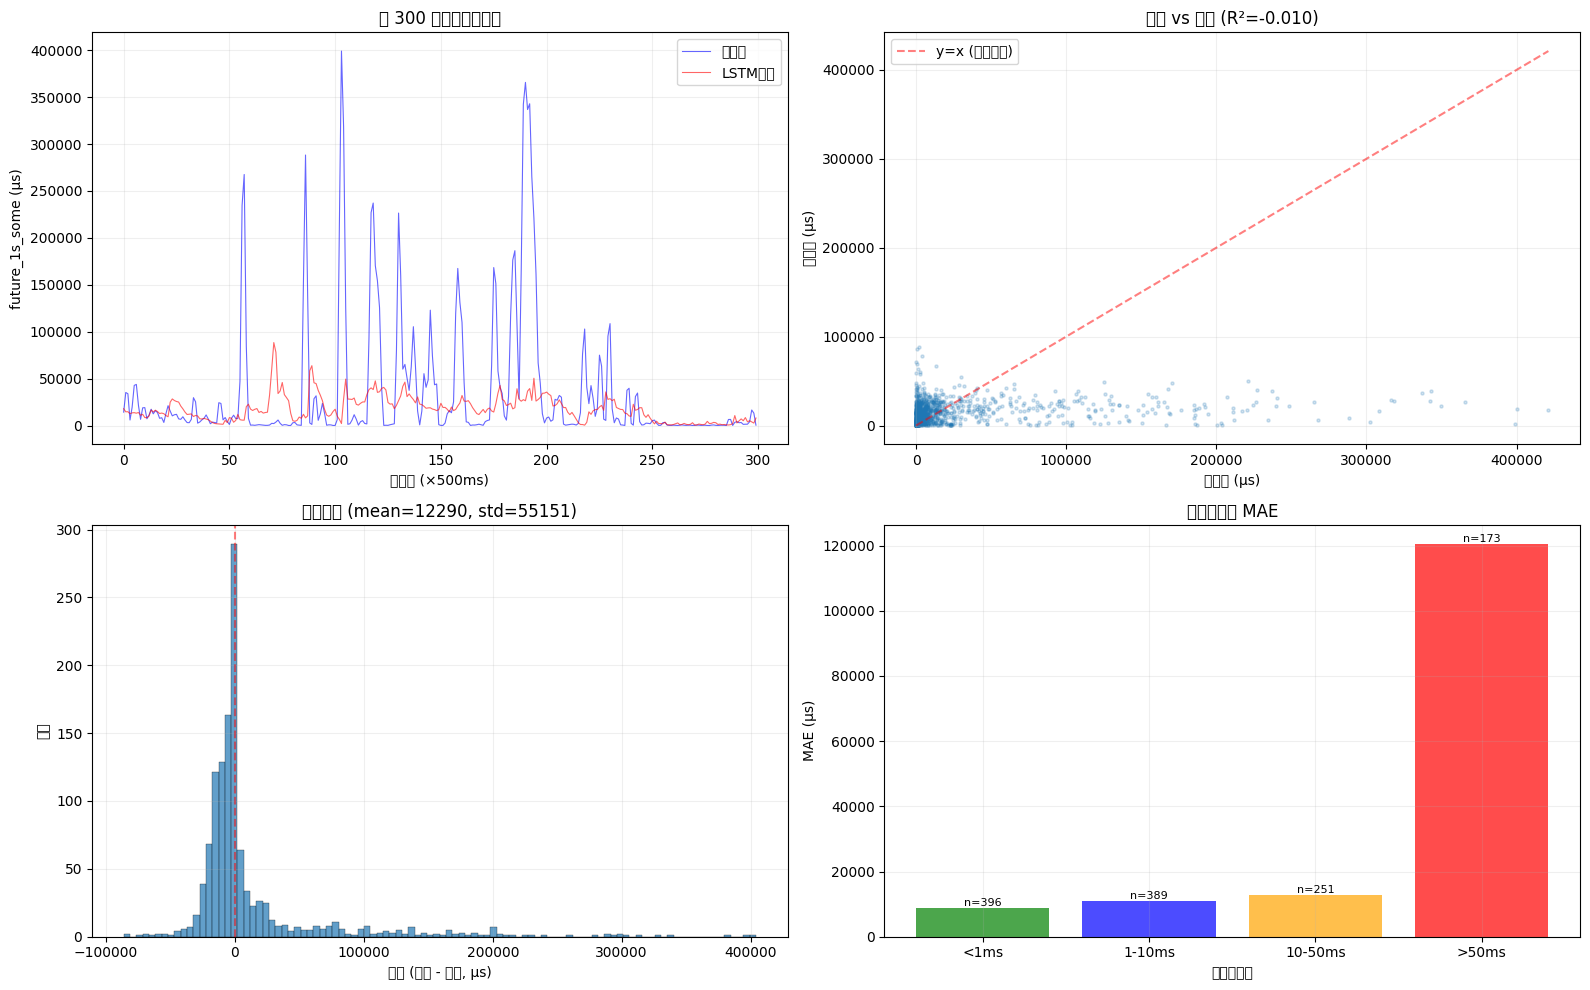

In [20]:
# Cell 9: 可视化预测 vs 真实
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 左上: 时序对比 (前 300 个点)
n_show = min(300, len(y_true_us))
axes[0, 0].plot(y_true_us[:n_show], 'b-', alpha=0.6, linewidth=0.8, label='真实值')
axes[0, 0].plot(y_pred_us[:n_show], 'r-', alpha=0.6, linewidth=0.8, label='LSTM预测')
axes[0, 0].set_xlabel('时间步 (×500ms)')
axes[0, 0].set_ylabel('future_1s_some (μs)')
axes[0, 0].set_title(f'前 {n_show} 个样本时序对比')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.2)

# 右上: 散点图
axes[0, 1].scatter(y_true_us, y_pred_us, alpha=0.2, s=5)
max_val = max(y_true_us.max(), y_pred_us.max())
axes[0, 1].plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='y=x (完美预测)')
axes[0, 1].set_xlabel('真实值 (μs)')
axes[0, 1].set_ylabel('预测值 (μs)')
axes[0, 1].set_title(f'真实 vs 预测 (R²={r2:.3f})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.2)

# 左下: 残差分布
residuals = y_true_us - y_pred_us
axes[1, 0].hist(residuals, bins=100, alpha=0.7, edgecolor='black', linewidth=0.3)
axes[1, 0].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('残差 (真实 - 预测, μs)')
axes[1, 0].set_ylabel('频数')
axes[1, 0].set_title(f'残差分布 (mean={residuals.mean():.0f}, std={residuals.std():.0f})')
axes[1, 0].grid(True, alpha=0.2)

# 右下: 分段误差 (低/中/高压力区间)
bins = [0, 1000, 10000, 50000, np.inf]
labels = ['<1ms', '1-10ms', '10-50ms', '>50ms']
bin_idx = pd.cut(y_true_us, bins=bins, labels=labels)
bin_mae = []
bin_counts = []
for lbl in labels:
    mask = bin_idx == lbl
    if mask.sum() > 0:
        bin_mae.append(mean_absolute_error(y_true_us[mask], y_pred_us[mask]))
        bin_counts.append(mask.sum())
    else:
        bin_mae.append(0)
        bin_counts.append(0)

bars = axes[1, 1].bar(labels, bin_mae, alpha=0.7, color=['green', 'blue', 'orange', 'red'])
for bar, cnt in zip(bars, bin_counts):
    axes[1, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                     f'n={cnt}', ha='center', va='bottom', fontsize=8)
axes[1, 1].set_xlabel('真实值区间')
axes[1, 1].set_ylabel('MAE (μs)')
axes[1, 1].set_title('各压力区间 MAE')
axes[1, 1].grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

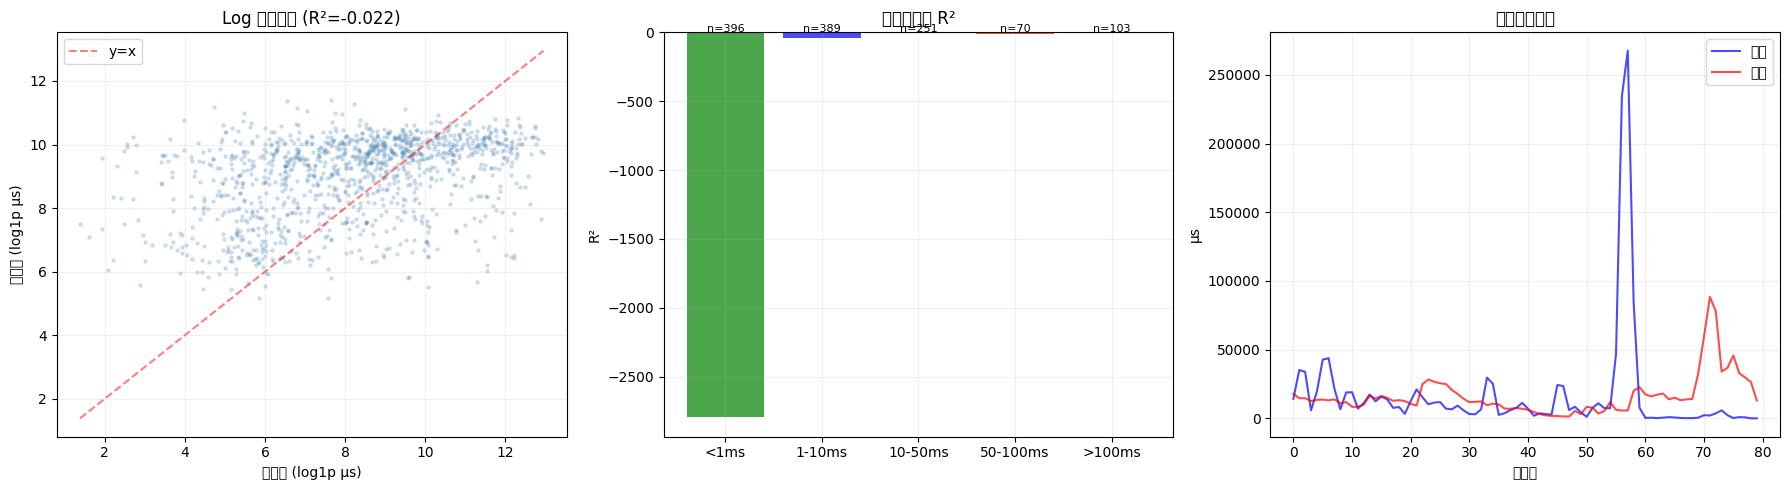

In [21]:
# Cell 10: 分段详细分析 + 高压区域预测能力
# 高压区域 (卡顿) 的预测能力是最重要的

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ========== 左: Log 空间散点图 ==========
axes[0].scatter(y_true_log, y_pred_log, alpha=0.2, s=5, c='steelblue')
lims = [min(y_true_log.min(), y_pred_log.min()), max(y_true_log.max(), y_pred_log.max())]
axes[0].plot(lims, lims, 'r--', alpha=0.5, label='y=x')
axes[0].set_xlabel('真实值 (log1p μs)')
axes[0].set_ylabel('预测值 (log1p μs)')
axes[0].set_title(f'Log 空间散点 (R²={r2_log:.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.2)

# ========== 中: 各区间 R² ==========
bins = [0, 1000, 10000, 50000, 100000, np.inf]
labels_bins = ['<1ms', '1-10ms', '10-50ms', '50-100ms', '>100ms']
r2_per_bin = []
counts_per_bin = []
for i in range(len(bins) - 1):
    mask = (y_true_us >= bins[i]) & (y_true_us < bins[i+1])
    cnt = mask.sum()
    counts_per_bin.append(cnt)
    if cnt > 10 and y_true_us[mask].std() > 0:
        r2_per_bin.append(r2_score(y_true_us[mask], y_pred_us[mask]))
    else:
        r2_per_bin.append(0)

colors = ['green', 'blue', 'orange', 'red', 'darkred']
bars = axes[1].bar(labels_bins, r2_per_bin, color=colors, alpha=0.7)
for bar, cnt in zip(bars, counts_per_bin):
    axes[1].text(bar.get_x() + bar.get_width()/2, max(bar.get_height(), 0) + 0.01,
                  f'n={cnt}', ha='center', fontsize=8)
axes[1].set_ylabel('R²')
axes[1].set_title('各压力区间 R²')
axes[1].axhline(0, color='gray', linestyle='--', alpha=0.3)
axes[1].grid(True, alpha=0.2)

# ========== 右: 时序放大 (高压区域) ==========
# 找到连续高压区域
high_mask = y_true_us > y_true_us.mean()
# 找到 high_mask 为 True 的第一段连续区域
diffs = np.diff(high_mask.astype(int))
starts = np.where(diffs == 1)[0]
if len(starts) > 0:
    seg_start = starts[0]
    seg_end = min(seg_start + 80, len(y_true_us))
    axes[2].plot(range(seg_end - seg_start), y_true_us[seg_start:seg_end], 'b-', alpha=0.7, label='真实')
    axes[2].plot(range(seg_end - seg_start), y_pred_us[seg_start:seg_end], 'r-', alpha=0.7, label='预测')
    axes[2].set_xlabel('时间步')
    axes[2].set_ylabel('μs')
    axes[2].set_title('高压区域放大')
    axes[2].legend()
axes[2].grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

In [22]:
# Cell 11: 导出模型 + 二分类对比评估
import json, os

os.makedirs("../model", exist_ok=True)

torch.save({
    'model_state_dict': model.state_dict(),
    'scaler_X_center': scaler_X.center_.tolist(),
    'scaler_X_scale': scaler_X.scale_.tolist(),
    'scaler_y_mean': float(scaler_y.mean_[0]),
    'scaler_y_scale': float(scaler_y.scale_[0]),
    'feature_names': FEATURES,
    'seq_len': SEQ_LEN,
    'hidden_dim': 96,
    'n_layers': 2,
    'target_transform': 'log1p',
    'metrics': {
        'mae_us': float(mae), 'rmse_us': float(rmse),
        'r2': float(r2), 'r2_log': float(r2_log), 'mape': float(mape),
    },
}, "../model/lstm_some.pt")
print("✓ 模型保存: model/lstm_some.pt")

# ========== 二分类评估 (与 XGBoost 对比) ==========
SPIKE_THRESHOLD = df[TARGET].quantile(0.90)
print(f"\n卡顿阈值 (90th): {SPIKE_THRESHOLD:,.0f} μs ({SPIKE_THRESHOLD/1000:.1f} ms)")

y_true_binary = (y_true_us > SPIKE_THRESHOLD).astype(int)
y_pred_binary = (y_pred_us > SPIKE_THRESHOLD).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, average_precision_score

cm = confusion_matrix(y_true_binary, y_pred_binary)
print(f"\n=== LSTM 二分类 (回归值>{SPIKE_THRESHOLD:.0f}μs → 卡顿) ===")
print(f"               预测平稳(0)  预测卡顿(1)")
print(f"实际平稳(0):      {cm[0][0]}          {cm[0][1]}  (误报)")
print(f"实际卡顿(1):      {cm[1][0]}  (漏报)   {cm[1][1]}")
print(f"\n{classification_report(y_true_binary, y_pred_binary)}")

# 用归一化的预测概率计算 PR-AUC
y_score = y_pred_us / y_pred_us.max()  # 归一化为 0~1 作 连续评分
ap = average_precision_score(y_true_binary, y_score)
print(f"PR-AUC (回归值作为评分): {ap:.4f}")
print("\n✓ 可与 XGBoost 分类 PR-AUC 直接对比")

✓ 模型保存: model/lstm_some.pt

卡顿阈值 (90th): 98,068 μs (98.1 ms)

=== LSTM 二分类 (回归值>98068μs → 卡顿) ===
               预测平稳(0)  预测卡顿(1)
实际平稳(0):      1104          0  (误报)
实际卡顿(1):      105  (漏报)   0

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1104
           1       0.00      0.00      0.00       105

    accuracy                           0.91      1209
   macro avg       0.46      0.50      0.48      1209
weighted avg       0.83      0.91      0.87      1209

PR-AUC (回归值作为评分): 0.1419

✓ 可与 XGBoost 分类 PR-AUC 直接对比
